In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets,transforms
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [22]:
folders=['/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign','/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant']
size=256

In [92]:
def load_image(path, size=256, grayscale=True, augment=False):
    mode = 'L' if grayscale else 'RGB'
    img = Image.open(path).convert(mode)
    img = img.resize((size, size))

    # Define transforms
    transform_list = []

    if augment:
        transform_list.extend([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),  # rotate ±20 degrees
        ])

    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)

    image = transform(img)

    return image

In [97]:
# Load dataset
def load_data(folders, size=256, augment=False):
    images = []
    masks = []
    prev_image, current_mask = None, None

    for folder in folders:
        folder_files = sorted(glob(folder + '/*'))

        for fp in folder_files:
            # Apply augmentation only to images, not masks
            is_mask = 'mask' in fp.lower()
            img = load_image(fp, size=size, grayscale=True, augment=augment and not is_mask)

            if is_mask:
                current_mask = img if current_mask is None else (current_mask + img > 0.5).float()
            else:
                if prev_image is not None:
                    images.append(prev_image)
                    masks.append(current_mask)
                prev_image, current_mask = img, None

        # Append last image/mask pair in folder
        if prev_image is not None:
            images.append(prev_image)
            masks.append(current_mask)

    return torch.stack(images), torch.stack(masks)

In [98]:
class BUIdataset(Dataset):
    def __init__(self,images,masks):
        super().__init__()
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        return self.images[idx], self.masks[idx]
    

In [99]:
images, masks = load_data(folders, size =256, augment=True)
dataset = BUIdataset(images, masks)

train_set = int(0.8 * len(dataset))
test_set = len(dataset) - train_set

train_dataset, test_dataset = random_split(dataset, [train_set,test_set], generator=torch.Generator().manual_seed(42))


In [100]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [101]:
len(dataset)

648

In [103]:
class convblock(nn.Module):
    def __init__(self,in_channels,out_channels,dropout=0.2):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
                                  nn.BatchNorm2d(out_channels),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout2d(dropout),
                                  nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
                                  nn.BatchNorm2d(out_channels),
                                  nn.ReLU(inplace=True))         
    def forward(self,x):
        return self.conv(x)                                    

In [104]:
class Encoder(nn.Module):
    def __init__(self,in_channels,out_channels,dropout=0.2):
        super().__init__()
        self.d_conv = convblock(in_channels,out_channels,dropout)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self,x):
        x_conv = self.d_conv(x)
        x_pool = self.maxpool(x_conv)
        return x_conv,x_pool
        
        

In [105]:
class Decoder(nn.Module):
     def __init__(self,in_channels,out_channels):
         super().__init__()
         self.up_conv = nn.ConvTranspose2d(in_channels,out_channels,kernel_size=2,stride=2, padding=0)
         self.conv = nn.Sequential(
            # Input channels must be out_channels * 2 (from upsampling + skip connection)
            nn.Conv2d(out_channels*2, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

     def forward(self, x, skip_con): # Note the input arguments
         # 1. Upsample the main feature map
         x = self.up_conv(x) 
         
         # 2. Concatenate with the skip connection
         x = torch.cat([x, skip_con], dim=1) # FIX APPLIED HERE: Use 'x'
         
         # 3. Apply the double convolution
         x = self.conv(x)

         return x

In [106]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        # Encoder
        self.enc1 = Encoder(in_channels, 64, dropout=0.2)
        self.enc2 = Encoder(64, 128, dropout=0.2)
        self.enc3 = Encoder(128, 256, dropout=0.2)
        self.enc4 = Encoder(256, 512, dropout=0.2)

        # Bottleneck
        self.bottleneck = convblock(512, 1024, dropout=0.3)

        # Decoder
        self.dec4 = Decoder(1024, 512)
        self.dec3 = Decoder(512, 256)
        self.dec2 = Decoder(256, 128)
        self.dec1 = Decoder(128, 64)

        # Output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        s1, p1 = self.enc1(x)
        s2, p2 = self.enc2(p1)
        s3, p3 = self.enc3(p2)
        s4, p4 = self.enc4(p3)

        b = self.bottleneck(p4)

        d4 = self.dec4(b, s4)
        d3 = self.dec3(d4, s3)
        d2 = self.dec2(d3, s2)
        d1 = self.dec1(d2, s1)

        return torch.sigmoid(self.out_conv(d1))

In [107]:
model = Unet(in_channels=1,out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-5)

In [77]:
import torch

# ----- Pixel Accuracy -----
def pixel_accuracy(outputs, masks):
    outputs = torch.sigmoid(outputs)         # logits → probabilities
    preds = (outputs > 0.5).float()          # threshold at 0.5
    correct = (preds == masks).float()
    return correct.mean().item()


# ----- Dice Score -----
def dice_score(outputs, masks, eps=1e-7):
    outputs = torch.sigmoid(outputs)
    preds = (outputs > 0.5).float()

    intersection = (preds * masks).sum()
    union = preds.sum() + masks.sum()
    dice = (2 * intersection + eps) / (union + eps)
    return dice.item()


# ----- IoU (Jaccard Index) -----
def iou_score(outputs, masks, eps=1e-7):
    outputs = torch.sigmoid(outputs)
    preds = (outputs > 0.5).float()

    intersection = (preds * masks).sum()
    union = preds.sum() + masks.sum() - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.item()


In [78]:
def evaluate_on_test(model, test_loader, device):
    model.eval()

    total_acc = 0
    total_dice = 0
    total_iou = 0
    count = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)

            total_acc += pixel_accuracy(outputs, masks)
            total_dice += dice_score(outputs, masks)
            total_iou += iou_score(outputs, masks)

            count += 1

    return total_acc / count, total_dice / count, total_iou / count


In [75]:
def evaluate(model, dataloader, device):
    model.eval()
    total_acc = 0
    total_dice = 0
    total_iou = 0
    count = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)

            total_acc += pixel_accuracy(outputs, masks)
            total_dice += dice_score(outputs, masks)
            total_iou += iou_score(outputs, masks)

            count += 1

    return total_acc / count, total_dice / count, total_iou / count


In [79]:
acc, dice, iou = evaluate(model, test_loader, device)

print(f"Accuracy: {acc:.4f}")
print(f"Dice:     {dice:.4f}")
print(f"IoU:      {iou:.4f}")


Accuracy: 0.9395
Dice:     0.7328
IoU:      0.5878


In [108]:
import torch
import torch.optim as optim

NUM_EPOCHS = 25

for epoch in range(NUM_EPOCHS):
    model.train()  # set model to training mode
    running_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Adding Noise
        noise = torch.randn_like(images)*0.01
        noisy_images = images + noise
        noisy_images = torch.clamp(noisy_images,0.0,1.0)

        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f}")

    # Lets evaluate on test set
    model.eval()
    running_test_loss = 0.0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)  # NO noise during testing
            loss = criterion(outputs, masks)
            running_test_loss += loss.item() * images.size(0)

    test_loss = running_test_loss / len(test_loader.dataset)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Test Loss: {test_loss:.4f}")

Epoch 1/25 - Train Loss: 0.4778
Epoch 1/25 - Test Loss: 0.4017
Epoch 2/25 - Train Loss: 0.3742
Epoch 2/25 - Test Loss: 0.3868
Epoch 3/25 - Train Loss: 0.3518
Epoch 3/25 - Test Loss: 0.3580
Epoch 4/25 - Train Loss: 0.3321
Epoch 4/25 - Test Loss: 0.3347
Epoch 5/25 - Train Loss: 0.3121
Epoch 5/25 - Test Loss: 0.3374
Epoch 6/25 - Train Loss: 0.2987
Epoch 6/25 - Test Loss: 0.3139
Epoch 7/25 - Train Loss: 0.2865
Epoch 7/25 - Test Loss: 0.3046
Epoch 8/25 - Train Loss: 0.2776
Epoch 8/25 - Test Loss: 0.2963
Epoch 9/25 - Train Loss: 0.2714
Epoch 9/25 - Test Loss: 0.2859
Epoch 10/25 - Train Loss: 0.2640
Epoch 10/25 - Test Loss: 0.2846
Epoch 11/25 - Train Loss: 0.2617
Epoch 11/25 - Test Loss: 0.2783
Epoch 12/25 - Train Loss: 0.2555
Epoch 12/25 - Test Loss: 0.2699
Epoch 13/25 - Train Loss: 0.2517
Epoch 13/25 - Test Loss: 0.2826
Epoch 14/25 - Train Loss: 0.2485
Epoch 14/25 - Test Loss: 0.2657
Epoch 15/25 - Train Loss: 0.2455
Epoch 15/25 - Test Loss: 0.2670
Epoch 16/25 - Train Loss: 0.2416
Epoch 16/2

In [119]:
import torch
import matplotlib.pyplot as plt

import random

def plot_multiple_outputs(model, test_loader, device, num_samples=5):
    model.eval()
    
    # Pick a random batch
    images, masks = random.choice(list(test_loader))
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        preds = (outputs > 0.5).float()

    plt.figure(figsize=(12, num_samples * 3))

    for i in range(num_samples):
        img = images[i].cpu().squeeze().numpy()
        mask = masks[i].cpu().squeeze().numpy()
        pred = preds[i].cpu().squeeze().numpy()

        # Image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img, cmap="gray")
        if i == 0: plt.title("Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(mask, cmap="gray")
        if i == 0: plt.title("Ground Truth")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred, cmap="gray")
        if i == 0: plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


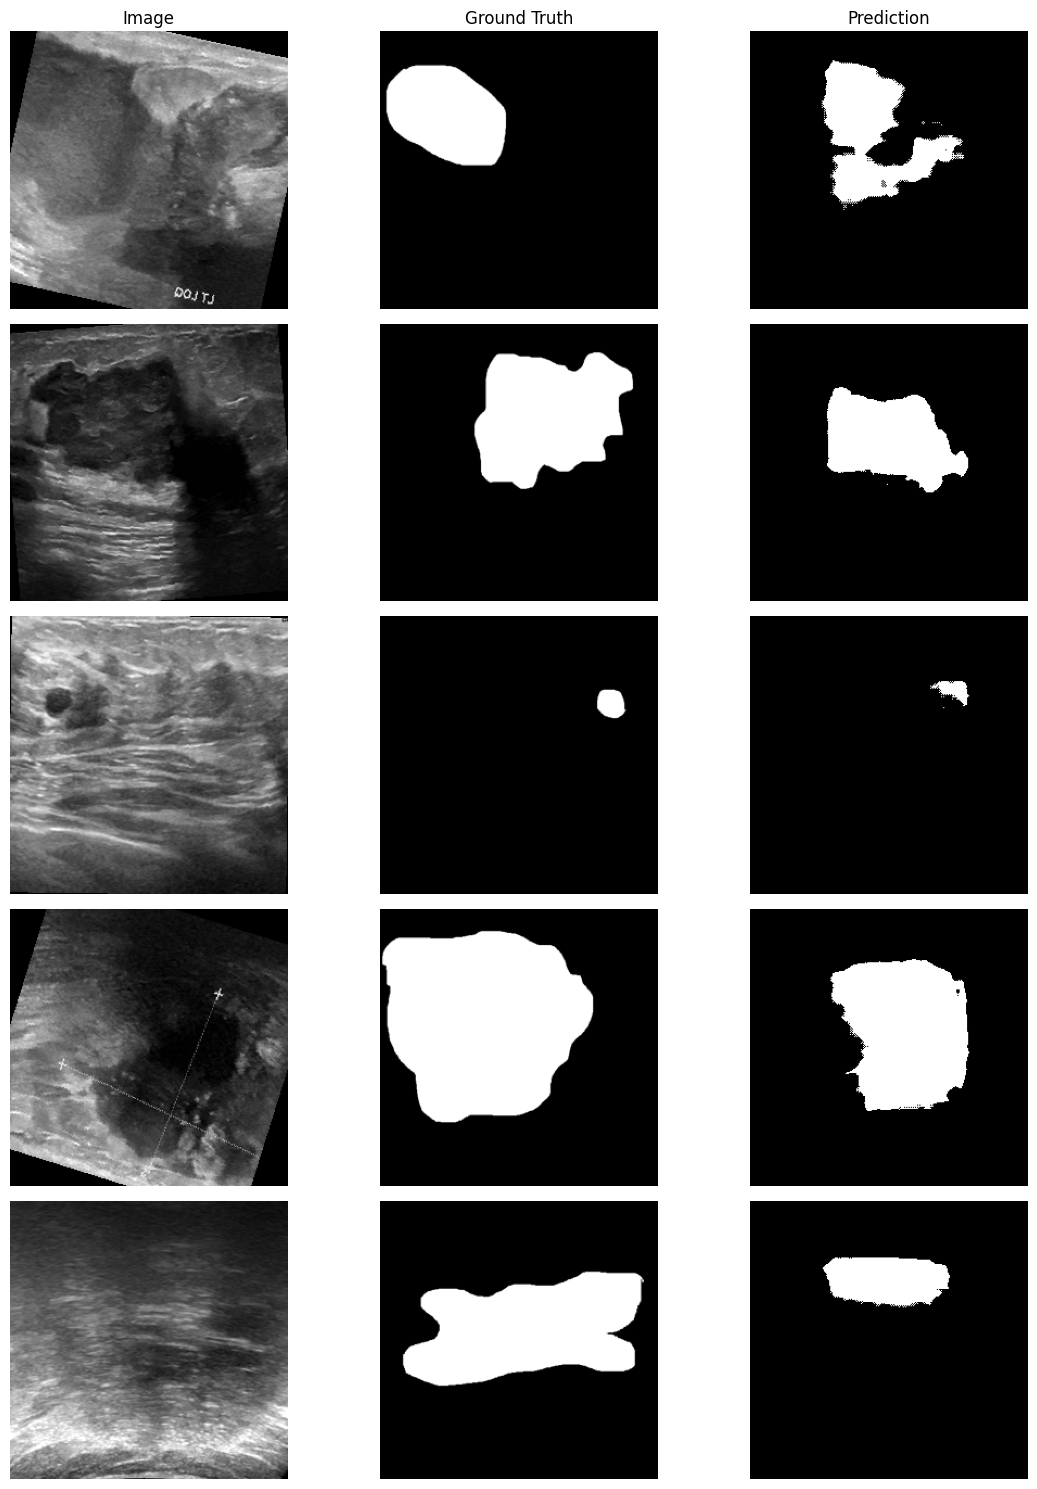

In [128]:
plot_multiple_outputs(model, test_loader, device, num_samples=5)
